# Behavioral Cloninig Project

---

## Training Pipeline with Keras and Generator

In [3]:
import os
import csv
import cv2
import time
import numpy as np
from math import ceil
import matplotlib.image as mpimg

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Dropout, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D

In [4]:
# Training params
validation_split = 0.2

# Create an sample array from driving_log.csv
samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

# Create train and validation samples filenames arrays
train_samples, validation_samples = train_test_split(shuffle(samples), test_size=validation_split)

In [5]:
# Define generator function
def generator(samples, batch_size=32):
    num_samples = len(samples)

    # Relative paths
    data_files_path_origin = 'data/'
    data_files_path_running = 'data/'

    # Steering correction definition
    steering_correction = 0.2
    steering_correction_arr = [0.0, steering_correction, -1.0*steering_correction]

    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []

            # Iterate over each sample in batch_samples
            for batch_sample in batch_samples:
                # Get the center, left and right images and steering angles (corrected when apply) from each sample
                # This will increases three times the training dataset
                for i in range(len(steering_correction_arr)):
                    if data_files_path_origin != data_files_path_running:
                        source_path = batch_sample[i]
                        filename = source_path.split('/')[-1]
                        batch_sample_path = data_files_path_running + 'IMG/' + filename
                    else:
                        batch_sample_path = batch_sample[i]

                    # Append sample image and the respective steering angle measurement with the proper steering_correction value
                    image = mpimg.imread(batch_sample_path)
                    images.append(image)
                    measurement = float(batch_sample[3]) + steering_correction_arr[i]
                    measurements.append(measurement)

                    # Append a new augmented version of each sample by fliping it image in vertical and inverting measurement sign
                    # This will duplicate the training dataset
                    images.append(cv2.flip(image,1))
                    measurements.append(-1.0*measurement)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

In [6]:
# print dataset statistics
def count_steering_dir(samples):
    straight_arr = np.array([0 for row in samples if float(row[3]) == 0])
    straight_arr_positive_comp = straight_arr+0.2
    straight_arr_negative_comp = straight_arr-0.2

    steer_left_arr = np.array([float(row[3]) for row in samples if float(row[3]) < 0])
    steer_left_arr_positive_comp = steer_left_arr+0.2
    steer_left_arr_negative_comp = steer_left_arr-0.2

    steer_right_arr = np.array([float(row[3]) for row in samples if float(row[3]) > 0])
    steer_right_arr_positive_comp = steer_right_arr+0.2
    steer_right_arr_negative_comp = steer_right_arr-0.2


    steer_arr = np.hstack((straight_arr,
                            straight_arr_positive_comp,
                            straight_arr_negative_comp,
                            steer_left_arr,
                            steer_left_arr_positive_comp,
                            steer_left_arr_negative_comp,
                            steer_right_arr,
                            steer_right_arr_positive_comp,
                            steer_right_arr_negative_comp))

    straight = np.count_nonzero(steer_arr == 0)
    steer_left = np.count_nonzero(steer_arr < 0)
    steer_right = np.count_nonzero(steer_arr > 0)

    max_left = min(steer_arr)
    max_right = max(steer_arr)

    return [straight, steer_left, steer_right,max_left,max_right,len(steer_arr)]
train_stats = count_steering_dir(train_samples)
validation_stats = count_steering_dir(validation_samples)
print("Dataset Summary (considering center, left, and right images, all of them with an augmented version")
print("Total train samples   = {}\n   | Distribuition (Center,Left,Right) = ({:.2f},{:.2f},{:.2f})\n   | Min/Max Steering (Left,Right) = ({:.2f},{:.2f})".format(train_stats[5]*2, train_stats[0]/train_stats[5], train_stats[1]/train_stats[5], train_stats[2]/train_stats[5], train_stats[3], train_stats[4]))
print("Total validation samples = {}\n   | Distribuition (Center,Left,Right) = ({:.2f},{:.2f},{:.2f})\n   | Min/Max Steering (Left,Right) = ({:.2f},{:.2f})".format(validation_stats[5]*2, validation_stats[0]/validation_stats[5], validation_stats[1]/validation_stats[5], validation_stats[2]/validation_stats[5], validation_stats[3], validation_stats[4]))

Dataset Summary (considering center, left, and right images, all of them with an augmented version
Total train samples   = 13680
   | Distribuition (Center,Left,Right) = (0.24,0.42,0.33)
   | Min/Max Steering (Left,Right) = (-1.20,1.20)
Total validation samples = 3420
   | Distribuition (Center,Left,Right) = (0.24,0.42,0.34)
   | Min/Max Steering (Left,Right) = (-0.80,1.20)


In [21]:
# Initialize Keras sequential model
model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/ 255.0 -0.5,input_shape=(160,320,3)))
# Crop image on the relevant area of the road
model.add(Cropping2D(cropping=((70,25),(0,0))))

# Build model published by the autonomous vehicle team at NVIDIA
model.add(Convolution2D(24,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(36,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(48,(5,5),strides=(2,2),activation="relu"))
model.add(Convolution2D(64,(3,3),activation="relu"))
model.add(Convolution2D(64,(3,3),activation="relu"))
model.add(Flatten())
model.add(Dense(100,activation="relu"))
model.add(Dense(50,activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(10,activation="relu"))
# model.add(Dropout(0.2))
model.add(Dense(1))

# Show model layers summary
print("\nModel Summary:")
model.summary()


Model Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_4 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 158, 24)       1824      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 77, 36)        21636     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 5, 37, 48)         43248     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 3, 35, 64)         27712     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 33, 64)         36928

In [22]:
# Training params
epoch = 10
# Set our batch size
# NOTE: The three images (Center, Left and Right) from sample and their respective augmented version are add to the training dataset, so each sample results in 6 images/measurements. The generator will return 6 times the batch_size of data to train
pre_batch_size = 22
pre_processing_factor = 6

# Compile and train the model using the generator function.
# NOTE: passing pre_batch_size because generator will internally append 6 images per sample
train_generator = generator(train_samples, batch_size=pre_batch_size)
validation_generator = generator(validation_samples, batch_size=pre_batch_size)

print("\nTraining params:")
print("Epochs\t\t\t\t= {}".format(epoch))
print("Batch size\t\t\t= {}".format(pre_batch_size * pre_processing_factor))
print("Total training samples  \t= {}\t| steps per batch = {}".format(len(train_samples)*pre_processing_factor, ceil(len(train_samples)/pre_batch_size)))
print("Total validation samples\t= {}\t| steps per batch = {}".format(len(validation_samples)*pre_processing_factor, ceil(len(validation_samples)/pre_batch_size)))
print("\nStart training with generator:\n")

# Train model with mean square error loss and adam optimizer
ts = time.time()
model.compile(loss='mse', optimizer='adam')
generator_history_object = model.fit_generator(train_generator, 
                                steps_per_epoch=ceil(len(train_samples)/pre_batch_size),
                                validation_data=validation_generator,
                                validation_steps=ceil(len(validation_samples)/pre_batch_size),
                                epochs=epoch, 
                                verbose=2)
# Save model
model.save('model_dropout_{}_{}.h5'.format(epoch,int(ts)))
print("Model saved! Filename: model_dropout_{}_{}.h5".format(epoch,int(ts)))


Training params:
Epochs				= 10
Batch size			= 192
Total training samples  	= 13680	| steps per batch = 72
Total validation samples	= 3420	| steps per batch = 18

Start training with generator:

Epoch 1/10
 - 74s - loss: 0.0371 - val_loss: 0.0326
Epoch 2/10
 - 71s - loss: 0.0316 - val_loss: 0.0290
Epoch 3/10
 - 72s - loss: 0.0297 - val_loss: 0.0280
Epoch 4/10
 - 69s - loss: 0.0287 - val_loss: 0.0277
Epoch 5/10
 - 69s - loss: 0.0276 - val_loss: 0.0284
Epoch 6/10
 - 69s - loss: 0.0271 - val_loss: 0.0281
Epoch 7/10
 - 68s - loss: 0.0262 - val_loss: 0.0281
Epoch 8/10


KeyboardInterrupt: 

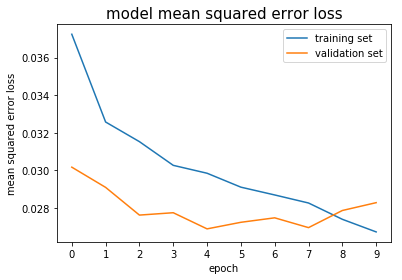

In [19]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

### plot the training and validation loss for each epoch
plt.plot(generator_history_object.history['loss'])
plt.plot(generator_history_object.history['val_loss'])
plt.title('model mean squared error loss', fontsize=15)
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.xticks(np.arange(len(generator_history_object.history['loss'])))
plt.legend(['training set', 'validation set'], loc='upper right')
plt.savefig("training_mse_{}_{}.png".format(epoch,int(ts)))
plt.show()

In [11]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_{}_{}_plot.png'.format(epoch,int(ts)), show_shapes=True, show_layer_names=True)